In [1]:
import sys, os

# Add utility_scripts in the current path so that they can be imported directly just like in interactive mode
sys.path.append(os.path.abspath("../usr/lib/"))
for script_folder in os.listdir("../usr/lib/"):
    sys.path.append(os.path.abspath("../usr/lib/"+script_folder))

In [2]:
from statistics import mean
import pickle

import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from lastquerytransformer import Riiid
from riiidutils import RiiidDataset, riiid_collate_fn

In [3]:
loc = os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost')
if loc == 'Interactive' or loc == 'Localhost':
    conf = {
        'batch_size': 4,
        'train_size': 8_000,
        'epochs': 10,
    }
# When it is run after an api push.
elif loc == 'Batch':
    conf = {
        'batch_size': 16,
        'train_size': 160_000,
        'epochs': 30,
    }

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Introduction

Le fichier train.csv comprend un peu plus de 100 millions de lignes.  
Il y a un peu moins de 400 mille user_id uniques.  
Le modèle utilisé dans ce notebook prend en entrée une série par utilisateur.

# Features utilisées
Pour chaque question de la série d'apprentissage d'un utilisateur quelconque  

1. Question ID: correspond à content_id (lorsque l'élément est une question).
2. Question part: correspond à part dans question.csv pour l'élément dont question_id correspondant à content_id
3. Answer correctness: valeur de answered_correctly de l'exemple (ou target encoding de la question ?)
4. Current question elapsed time: prior question de la question suivante.
5. Timestamp difference: current question timestamp - timestamp of the last question from the same user

# Chargement des données et instanciation des datasets

In [5]:
with open('../input/riiid-sequences/users_y.pickle', 'rb') as f:
    users_y = pickle.load(f)
with open('../input/riiid-sequences/users_cat.pickle', 'rb') as f:
    users_cat = pickle.load(f)
with open('../input/riiid-sequences/users_cont.pickle', 'rb') as f:
    users_cont = pickle.load(f)

In [6]:
cat_train, cat_val, cont_train, cont_val, y_train, y_val = train_test_split(users_cat, users_cont, users_y, test_size=.05)

In [7]:
cat_train = cat_train[:conf['train_size']]
cont_train = cont_train[:conf['train_size']]
y_train = y_train[:conf['train_size']]

In [8]:
print(len(y_train), len(y_val))

8000 19683


## Batches
Dynamic Padding: ajout de padding batch par batch pour avoir une même longueur de séquence dans chaque batch.  
Uniform size batching: on trie les utilisateurs par longueur de séquence, afin d'avoir des longueurs plus proches dans chaque batch  

Afin de mettre en œuvre ces deux stratégies on va par simplicité trier au préalable et conjointement les listes batch_cat, batch_cont et batch_y par longueur des séquences dans batch_cat/batch_cont (c'est RiiidDataset qui s'en charge). Le DataLoader utilisera une fonction collate_fn permettant d'ajouter du padding dynamiquement batch par batch.

In [9]:
train_dataset = RiiidDataset(cat_train, cont_train, y_train)
val_dataset = RiiidDataset(cat_val, cont_val, y_val)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=conf['batch_size'], shuffle=False, collate_fn=riiid_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=conf['batch_size'], shuffle=False, collate_fn=riiid_collate_fn)

# Modèle
Pour le modèle, l'auteur s'est inspiré de la solution arrivée 3è à la compétition [Data Science bowl 2019](https://www.kaggle.com/c/data-science-bowl-2019/discussion/127891)  
La procédure de création des embeddings est expliquée, on suppose que l'auteur s'est basé dessus.
## Embeddings
On utilise un embedding catégoriel pour les 3 premières variables et un embedding continu pour les 2 dernières.
Contrairement à la solution du lien ci-dessus on utilise un embedding catégoriel par variable catégorielle plutôt qu'un embedding commun, comme recommandé [ici](https://discuss.pytorch.org/t/categorical-embeddings-can-i-only-have-1-categorical-column-per-embedding-layer/104681/3)

In [11]:
maximums = {'question_id': 13523, 'part': 7, 'answered_correctly': 3}
model = Riiid(maximums).to(device)

# Training

In [12]:
LEARNING_RATE = 1e-6
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [13]:
def evaluate(model, iterator, criterion):
    model.eval()
    losses = []
    accuracies = []
    y_true = []
    y_score = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            x_cat = batch['cat'].to(device)
            x_cont = batch['cont'].to(device)
            y = batch['y'].to(device)

            ypred = model(x_cat, x_cont).squeeze(0).squeeze(1)
            loss = criterion(ypred, y)

            losses.append(float(loss))
            accuracies.append((torch.round(torch.sigmoid(ypred)) == y).float().mean().item())
            y_true.extend(y.cpu().numpy())
            y_score.extend(torch.sigmoid(ypred).cpu().numpy())

    return mean(losses), mean(accuracies), roc_auc_score(y_true, y_score)

In [14]:
losses = []
accuracies = []
auc = []
val_losses = []
val_accuracies = []
val_auc = []

In [16]:
# we use 2 writers so we can have the train and val scalars on the same plots
LOG_DIR = "tensorboard"
train_writer = SummaryWriter(os.path.join(LOG_DIR, "train"))
val_writer = SummaryWriter(os.path.join(LOG_DIR, "val"))

for e in range(conf['epochs']):
    model.train()
    e_losses = []
    e_accuracies = []
    y_true = []
    y_score = []
    print("Epoch ", e)
    for batch in train_loader:
        x_cat = batch['cat'].to(device)
        x_cont = batch['cont'].to(device)
        y = batch['y'].to(device)

        # squeeze() will remove the 3 dimensions if batch_size = 1
        ypred = model(x_cat, x_cont).squeeze(0).squeeze(1)
        loss = criterion(ypred, y)
        with torch.no_grad():
            e_losses.append(float(loss))
            e_accuracies.append((torch.round(torch.sigmoid(ypred)) == y).float().mean().item())
            y_true.extend(y.cpu().numpy())
            y_score.extend(torch.sigmoid(ypred).cpu().numpy())

        model.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(mean(e_losses))
    accuracies.append(mean(e_accuracies))
    auc.append(roc_auc_score(y_true, y_score))
    val_l, val_acc, val_area = evaluate(model, val_loader, criterion)
    val_accuracies.append(val_acc)
    val_losses.append(val_l)
    val_auc.append(val_area)
    print("Loss:", losses[-1])
    print("Accuracy:", accuracies[-1])
    print("AUC:", auc[-1])
    print("Validation loss:", val_losses[-1])
    print("Validation accuracy:", val_accuracies[-1])
    print("Validation AUC:", val_auc[-1])
    train_writer.add_scalar("Loss", losses[-1], e)
    train_writer.add_scalar("Accuracy", accuracies[-1], e)
    train_writer.add_scalar("AUC", auc[-1], e)
    val_writer.add_scalar("Loss", val_losses[-1], e)
    val_writer.add_scalar("Accuracy", val_accuracies[-1], e)
    val_writer.add_scalar("AUC", val_auc[-1], e)

train_writer.close()
val_writer.close()

Epoch  0
Loss: 0.6928760153651238
Accuracy: 0.516
AUC: 0.5262787912640438
Validation loss: 0.6902672914416053
Validation accuracy: 0.5599132967574207
Validation AUC: 0.5795380845456366
Epoch  1
Loss: 0.6886333540976047
Accuracy: 0.5635
AUC: 0.6022779828312561
Validation loss: 0.6863318992518623
Validation accuracy: 0.5867879157373028
Validation AUC: 0.6271076311905617
Epoch  2
Loss: 0.6850135173797608
Accuracy: 0.582625
AUC: 0.628076321162631
Validation loss: 0.6829573272253725
Validation accuracy: 0.5946623315064555
Validation AUC: 0.6386795543787025
Epoch  3
Loss: 0.681886210501194
Accuracy: 0.588875
AUC: 0.6376845348297393
Validation loss: 0.6800091474963698
Validation accuracy: 0.5985233353674594
Validation AUC: 0.6444583897355873
Epoch  4
Loss: 0.6789786901772022
Accuracy: 0.59775
AUC: 0.6451748686562735
Validation loss: 0.677337318386302
Validation accuracy: 0.5996917970622369
Validation AUC: 0.6485290587990691
Epoch  5
Loss: 0.6763970129191875
Accuracy: 0.600375
AUC: 0.648954241

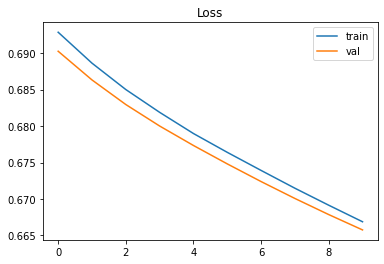

In [17]:
plt.plot(losses, label='train')
plt.plot(val_losses, label='val')
plt.title('Loss')
plt.legend()

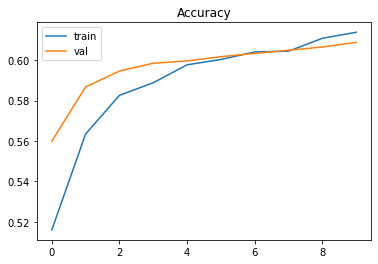

In [18]:
plt.plot(accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.title('Accuracy')
plt.legend()

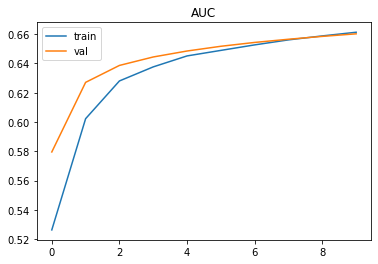

In [19]:
plt.plot(auc, label='train')
plt.plot(val_auc, label='val')
plt.title('AUC')
plt.legend()